In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [1]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [22]:
# Get the last data point in the db
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [23]:
# Perform a query to retrieve the last 12mon precipitation data & sort the dataframe by date
prev_12m_prcp = (dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()

prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prev_12m_prcp).\
order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data)
prcp_df.rename(columns={"prcp": "precipitation"}, inplace=True)
prcp_df.set_index("date", inplace=True)
prcp_df.sort_index()
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

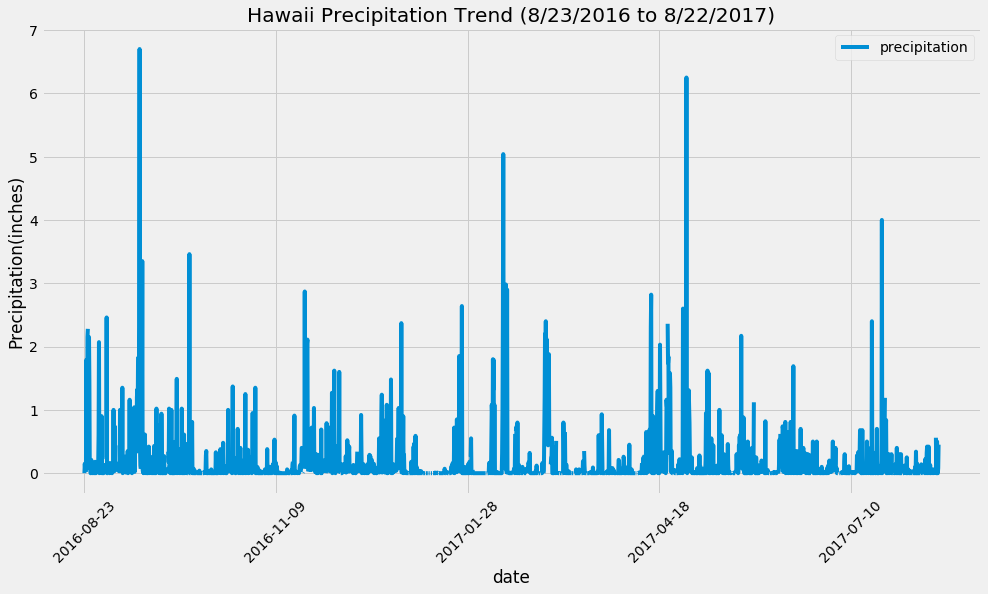

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(title = "Hawaii Precipitation Trend (8/23/2016 to 8/22/2017)",figsize= (15,8))
plt.ylabel("Precipitation(inches)")
plt.xticks(rotation=45)
#plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.name)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = most_active[0][0]
top_station_temps = list(session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == top_station))
top_station_temps

[(54.0, 85.0, 71.66378066378067)]

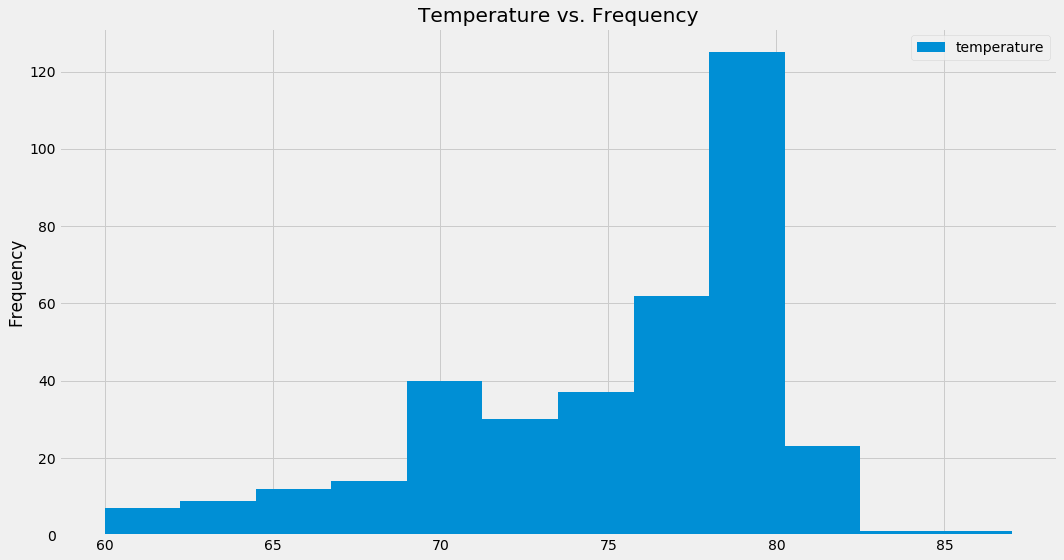

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_obs = session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.tobs).order_by(func.count(Measurement.id).desc()).first()
highest_obs_id = highest_obs [0]
top_prcp_data = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date >= prev_12m_prcp).\
    filter(Measurement.station == highest_obs_id)
    
tobs_df = pd.DataFrame(top_prcp_data)
tobs_df.rename(columns={"tobs": "temperature"}, inplace=True)
tobs_df.plot(kind='hist', bins=12, title="Temperature vs. Frequency", figsize= (15,8))
plt.tight_layout()

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

### APH Trip Dates: 6/3/17 - 6/13/17

start_date = '2016-06-03' 
end_date = '2016-06-13'

APH_trip_temps = calc_temps(start_date, end_date)
APH_trip_df = pd.DataFrame(APH_trip_temps, columns=['tmin', 'tavg', 'tmax'])
APH_trip_df

,tmin,tavg,tmax
0,65.0,74.338235,80.0


Text(0, 0.5, 'Temp (F)')

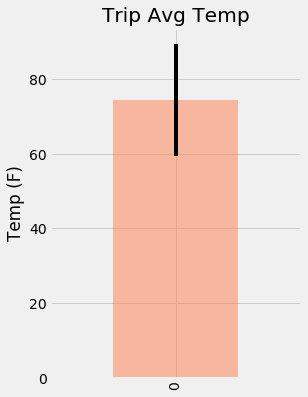

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
APH_trip_df.plot.bar(y='tavg', yerr=(APH_trip_df['tmax'] - APH_trip_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6), legend=False)
plt.ylabel('Temp (F)')


In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

trip_prcp=precipitation(start_date, end_date)
trip_prcp_df = pd.DataFrame(trip_prcp, columns=['Station', 'Location', 'Precipitation', 'Latitude', 'Longitude', 'Elevation'])
trip_prcp_df

,Station,Location,Precipitation,Latitude,Longitude,Elevation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.47
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.16
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.10
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.02
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.02
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


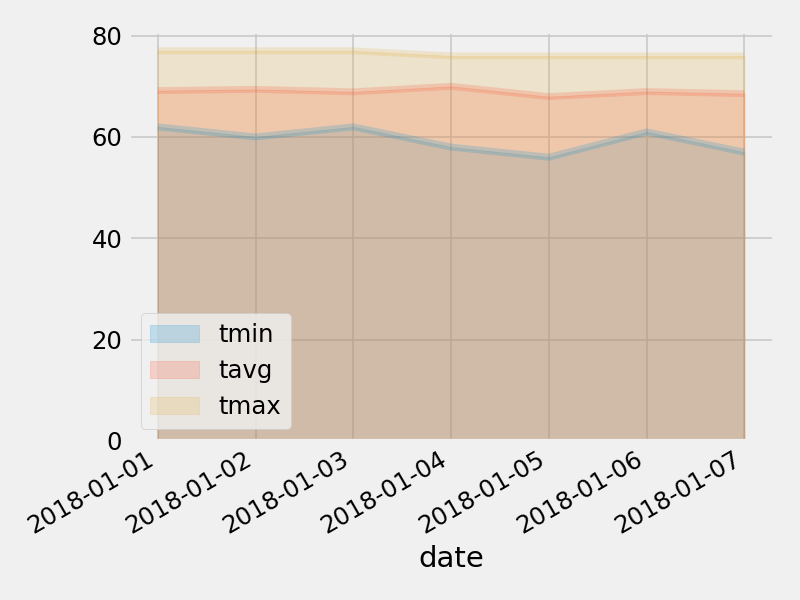

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
